In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install NetCDF4

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 327kB 29.1MB/s 


In [ ]:
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from netCDF4 import Dataset

# Arguments

In [ ]:
patch_size=(33,33)
input_shape=(patch_size[0],patch_size[1],1)
batch_size=64

# Load and Pre-process Low Resolution Data

In [ ]:
nc_f_low="/content/drive/My Drive/ISRO SAC Off Campus/sst_smooth_comp.nc"
nc_low = Dataset(nc_f_low, 'r')  # Dataset is the class behavior to open the file and create an instance of the ncCDF4 class

# Extract data from NetCDF file
lats_low = nc_low.variables['LAT'][:]  # extract/copy the data
lons_low = nc_low.variables['LON'][:]
time_low = nc_low.variables['TIME'][:]
sst_field_low = nc_low.variables['SST25'][:]  # shape is time, lat, lon as shown above

In [ ]:
nc_f_high = '/content/drive/My Drive/ISRO SAC Off Campus/sst1km_comp.nc'  # Your filename
nc_high = Dataset(nc_f_high, 'r')  # Dataset is the class behavior to open the file and create an instance of the ncCDF4 class

# Extract data from NetCDF file
lats = nc_high.variables['lat'][:]  # extract/copy the data
lons = nc_high.variables['lon'][:]
time = nc_high.variables['time'][:]
sst_field_high = nc_high.variables['sst'][:]  # shape is time, lat, lon as shown above

In [ ]:
def modify_sst(sst):
  sst_temp=sst.copy()
  missing=sst_temp.fill_value
  for index in range(sst.shape[0]):
    image=sst_temp[index].copy()
    image[image.data==missing]=0
    new_image=ma.masked_equal(image.data, 0)
    sst_temp[index]=new_image
  sst_temp.fill_value=0
  return sst_temp

In [ ]:
def normalise(sst, norm_constant):
  sst=sst/norm_constant
  return sst

In [ ]:
max_pixel=max(np.max(sst_field_high), np.max(sst_field_low))

In [ ]:
sst_low=modify_sst(sst_field_low)
sst_low_norm=normalise(sst_low, max_pixel)

In [ ]:
sst_high=modify_sst(sst_field_high)

Mask the Predicted Values which Don't lie in the Expected Range

In [ ]:
mask_value=np.min(sst_low_norm)-0.1

In [ ]:
del sst_field_low
del sst_field_high

# Model

In [ ]:
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv2D, Masking, add, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow import image
from tensorflow import float32
from tensorflow.keras import Input

In [ ]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peak Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    y_true=K.clip(y_true, 0, 1)
    y_pred=K.clip(y_pred, 0, 1)
    im1 = image.convert_image_dtype(y_true, float32)
    im2 = image.convert_image_dtype(y_pred, float32)
    return -10. * K.log(K.mean(K.square(im2 - im1))) / K.log(10.)

In [ ]:
input_img = Input(shape=input_shape)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(input_img)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(model)
res_img = model

output_img = add([res_img, input_img])

model = Model(input_img, output_img)

model.compile(loss=MeanSquaredError(),
              optimizer=Adam(),
              # metrics=['accuracy'])
              metrics=[PSNRLoss])

In [ ]:
model.load_weights('/content/drive/My Drive/ISRO SAC Off Campus/5km/VDSR/ckpts (50-91)/cp-0041.ckpt')

# Predict

In [ ]:
row_max=sst_low.shape[1]//33
col_max=sst_low.shape[2]//33

Suppose you had a total of 240 SST Fields (in the same NetCDF File) which comprised of both your train and test data. Say your train dataset comprised of 162 fields, so you're predicting only 30 fields here (test data). Lag in this case would be 170, so your days becomes total-lag=78!

In [ ]:
total=240

In [ ]:
lag=162

In [ ]:
days=total-lag

In [ ]:
sst_predict=np.zeros((days, sst_low_norm.shape[1], sst_low_norm.shape[2]))

In [ ]:
for day in range(days):

  for row in range(0, row_max*33, 33):
    for col in range(0, col_max*33, 33):
      low_patch=sst_low_norm[day+lag, row:row+33, col:col+33]
      predict=model.predict(low_patch.reshape((1,33,33,1)))
      sst_predict[day, row:row+33, col:col+33]=predict.reshape((33,33))
  
  last_row=sst_low_norm.shape[1]-33
  for col in range(0, col_max*33, 33):
      low_patch=sst_low_norm[day+lag, last_row:last_row+33, col:col+33]
      predict=model.predict(low_patch.reshape((1,33,33,1)))
      sst_predict[day, last_row:last_row+33, col:col+33]=predict.reshape((33,33))

  last_col=sst_low_norm.shape[2]-33
  for row in range(0, row_max*33, 33):
      low_patch=sst_low_norm[day+lag, row:row+33, last_col:last_col+33]
      predict=model.predict(low_patch.reshape((1,33,33,1)))
      sst_predict[day, row:row+33, last_col:last_col+33]=predict.reshape((33,33))

  predict_sst=ma.masked_less_equal(sst_predict, mask_value)


### Rescale

In [ ]:
sst_predict=predict_sst*max_pixel

# Write NetCDF

In [ ]:
 nc_predict = Dataset('sst_predict.nc','w', format='NETCDF4')

In [ ]:
nc_predict.createDimension('lon', len(lons_low))
nc_predict.createDimension('lat', len(lats_low))
# nc_predict.createDimension('sst', len(sst_predict))
nc_predict.createDimension('time', 1)

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1

In [ ]:
longitude = nc_predict.createVariable('Longitude', 'f4', 'lon')
latitude = nc_predict.createVariable('Latitude', 'f4', 'lat')  
sst = nc_predict.createVariable('SST', 'f4', ('time', 'lat', 'lon'))
time = nc_predict.createVariable('Time', 'f8', 'time')

In [ ]:
longitude[:] = lons_low
latitude[:] = lats_low
sst[:] = sst_predict[0]
time[:]=time_low[0]

In [ ]:
#Add global attributes
nc_predict.description = "Downsampled 3km Resolution Fields (via Deep Learning)"

#Add local attributes to variable instances
longitude.units = 'degrees east'
longitude.size=1092
# longitude.dtype= type('float32')
longitude.standard_name= 'longitude'
longitude.long_name= 'longitude'
longitude.axis='X'

latitude.units = 'degrees east'
latitude.size=547
# latitude.dtype= type('float32')
latitude.standard_name= 'latitude'
latitude.long_name= 'latitude'
latitude.axis='Y'

time.units = 'seconds since 1981-01-01 00:00:00'
time.size=78
# time.dtype= type('float64')
time.standard_name= 'time'
time.long_name= 'reference time of sst field'
time.axis='T'
time.calendar='standard'

sst.units = 'kelvin'
sst.size=46591272
# sst.dimensions=('time', 'lat', 'lon')
# sst.dtype= type('float32')
sst.standard_name= 'sea_surface_foundation_temperature'
sst.long_name= 'analysed sea surface temperature'
sst.axis='Y'


In [ ]:
 nc_predict.close()

In [ ]:
!cp '/content/sst_predict.nc' '/content/drive/My Drive/ISRO SAC Off Campus/5km/'

# Root Mean Square

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [ ]:
rmse(sst_predict[162],sst_high[162])

0.021429275636596943

In [ ]:
rmse(sst_low[162],sst_high[162])

0.007797260515281897

# PSNR

In [ ]:
def psnr(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Cannot calculate PSNR. Input shapes not same." \
                                         " y_true shape = %s, y_pred shape = %s" % (str(y_true.shape),
                                                                                   str(y_pred.shape))

    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

In [ ]:
psnr(sst_predict[162:240],sst_high[162:240])

33.63650415557337

In [ ]:
psnr(sst_low[162:240],sst_high[162:240])

41.14100648341588

In [ ]:
psnr(sst_low[0:161],sst_high[0:161])

41.231342531425256

In [ ]:
psnr(sst_low,sst_high)

41.18390716228939

# Gradient

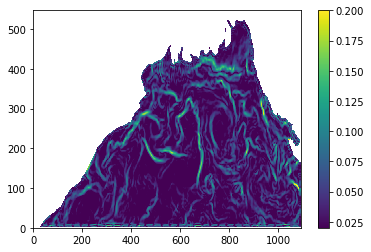

In [ ]:
gradient=np.gradient(sst_predict[172])
sobel=np.hypot(gradient[0],gradient[1])
plt.pcolormesh(sobel)
plt.clim(vmin=0.020, vmax=0.2)
plt.colorbar()

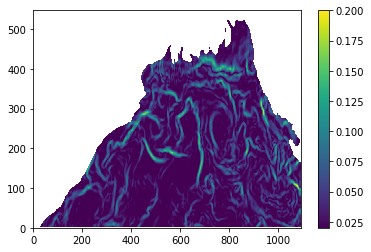

In [ ]:
gradient=np.gradient(sst_low[172])
sobel=np.hypot(gradient[0],gradient[1])
plt.pcolormesh(sobel)
plt.clim(vmin=0.020, vmax=0.2)
plt.colorbar()

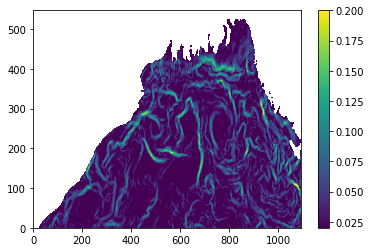

In [ ]:
gradient=np.gradient(sst_high[172])
sobel=np.hypot(gradient[0],gradient[1])
plt.pcolormesh(sobel)
plt.clim(vmin=0.020, vmax=0.2)
plt.colorbar()

# Read NetCDf

In [ ]:
nc = 'sst_predict.nc'  # Your filename
predict_nc = Dataset(nc, 'r')  # Dataset is the class behavior to open the file and create an instance of the ncCDF4 class

# Extract data from NetCDF file
lats = predict_nc.variables['Latitude'][:]  # extract/copy the data
lons = predict_nc.variables['Longitude'][:]
time = predict_nc.variables['Time'][:]
sst_predicted = predict_nc.variables['SST'][:]  # shape is time, lat, lon as shown above

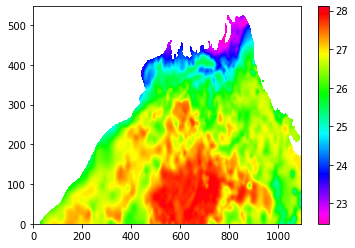

In [ ]:
plt.pcolormesh(sst_low[162], cmap='gist_rainbow_r')
plt.colorbar()